# Attempt 3 - Trees & Ensemble
Trying different types of models - ideally we can try AutoML approaches for everything including all the hyperparameter tuning and model exploration as out dataset is relatively clean is strictly relational, which we do not do here, so this is a halfway attempt whose sole goal is to maximize Kaggle score

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import copy
import numpy as np
import pandas as pd

from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from src.data.utils import read_df, get_xy
from src.nb_utils.data import summarize_df
from src.nb_utils.eval import plot_roc, plot_pr
from src.nb_utils.woe import summarize_woe_iv
from src.data.transforms.null_transform import null_transform
from src.data.transforms.simple_transform import log_almost_all_vars_transform_v2
from src.data.transforms.woe_transform import forced_binning, WoETransformV2
from src.models.fit import kfold_fit, df_train_test_stratify_split, fit_and_eval
from src.models.ensemble import Ensemble 
from src.models.models import StatsModelsLogisticRegression, XGBoostClassifier, LightGBMClassifier
from src.utils.eval import generate_test_output, eval_auc

## Read Data

In [2]:
raw_df = read_df("./data/dataset/cs-training.csv")
summarize_df(raw_df)

,N/A count,N/A fraction
Variable Name,,
MonthlyIncome,29731,0.198207
NumberOfDependents,3924,0.026160
SeriousDlqin2yrs,0,0.000000
RevolvingUtilizationOfUnsecuredLines,0,0.000000
age,0,0.000000
NumberOfTime30-59DaysPastDueNotWorse,0,0.000000
DebtRatio,0,0.000000
NumberRealEstateLoansOrLines,0,0.000000
NumberOfOpenCreditLinesAndLoans,0,0.000000


## Load saved transformations & logistic model

In [3]:
woe_v2_transform = WoETransformV2()
woe_v2_transform.load("./data/models/woe_fit_v2.pckl")

sm_model_woe_v2 = StatsModelsLogisticRegression("./data/models/sm_model_woe_v2.pckl")

## Define transformations
1. df_log_most_v2 - same as df_log_most_v2 in Attempt 1 - impute N/As, log(x), don't drop any variables
2. df - do nothing - no transformations, no imputations as trees will handle N/A
3. df_woe_v2 - same as that in Attempt 2 - don't drop any variables

In [4]:
df_log_most_v2, _ = log_almost_all_vars_transform_v2(raw_df)  # log(x) of most cols from Attempt 1
df, _ = null_transform(raw_df)  # null transform
df_woe_v2, _ = woe_v2_transform(raw_df)  # Attempt 2's WoE binning transform

## XGBoost Fit
Not surpirsingly, transformed data such as logged doesn't make too much of a difference to tree-baed methods as they already do non-linear partitioning when splitting nodes by feature threshold values.

In [5]:
print("XGB Classifier 1")
xg_cls_model_1 = kfold_fit(df_log_most_v2, 5, XGBoostClassifier)

print("XGB Classifier 2")
xg_cls_model_2 = kfold_fit(df_woe_v2, 5, XGBoostClassifier)

print("XGB Classifier 3")
xg_cls_model_3 = kfold_fit(df, 5, XGBoostClassifier)
xg_cls_model_3.save("./data/models/xg_cls_model_3.pckl")

XGB Classifier 1
kfold x-val for k=5
run 1 - class [0 1] for train=[111980   8020], test=[27994  2006] --> AUC=0.868
run 2 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.871
run 3 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.860
run 4 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.864
run 5 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.860
XGB Classifier 2
kfold x-val for k=5
run 1 - class [0 1] for train=[111980   8020], test=[27994  2006] --> AUC=0.870
run 2 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.862
run 3 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.853
run 4 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.866
run 5 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.854
XGB Classifier 3
kfold x-val for k=5
run 1 - class [0 1] for train=[111980   8020], test=[27994  2006] --> AUC=0.869
run 2 - c

## LightGBM Classifier
Same observation

In [6]:
print(f"LightGBM Classifier 1")
lgbm_model_1 = kfold_fit(df_log_most_v2, 5, LightGBMClassifier)

print(f"LightGBM Classifier 2")
lgbm_model_2 = kfold_fit(df_woe_v2, 5, LightGBMClassifier)

print(f"LightGBM Classifier 3")
lgbm_model_3 = kfold_fit(df, 5, LightGBMClassifier)
lgbm_model_3.save("./data/models/lgbm_model_3.pckl")

LightGBM Classifier 1
kfold x-val for k=5
run 1 - class [0 1] for train=[111980   8020], test=[27994  2006] --> AUC=0.863
run 2 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.866
run 3 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.864
run 4 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.867
run 5 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.861
LightGBM Classifier 2
kfold x-val for k=5
run 1 - class [0 1] for train=[111980   8020], test=[27994  2006] --> AUC=0.862
run 2 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.862
run 3 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.864
run 4 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.854
run 5 - class [0 1] for train=[111979   8021], test=[27995  2005] --> AUC=0.867
LightGBM Classifier 3
kfold x-val for k=5
run 1 - class [0 1] for train=[111980   8020], test=[27994  2006] --> AUC=

# Sanity check for proper Train/Test split AUC and PR Curves
Compared to logistic model there seems to be a mild overfitting in the tree-based methods (AUC is better bu ~0.3 for LightGBM)

### XGBoost

class [0 1] for train=[97982  7018], test=[41992  3008] - auc=0.860
Train


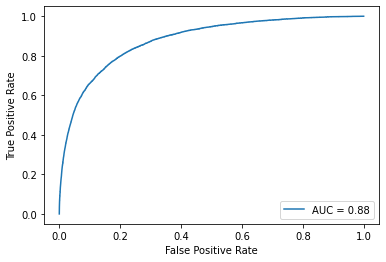

Test


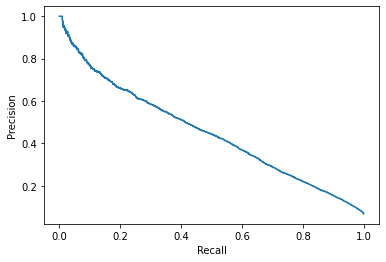

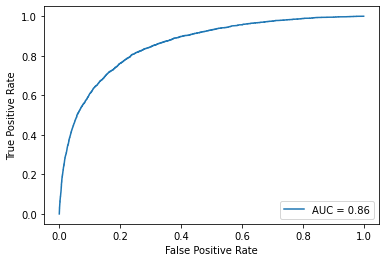

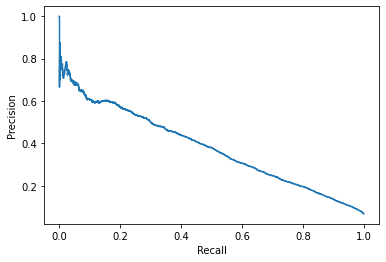

In [7]:
X_train, X_test, y_train, y_test = df_train_test_stratify_split(raw_df, test_size=0.3)

X_train, _ = null_transform(X_train)
X_test, _ = null_transform(X_test)

xg_cls_model_3_train_test = fit_and_eval(XGBoostClassifier, X_train, X_test, y_train, y_test)

print("Train")
plot_roc(xg_cls_model_3_train_test, X_train, y_train)
plot_pr(xg_cls_model_3_train_test, X_train, y_train)

print("Test")
plot_roc(xg_cls_model_3_train_test, X_test, y_test)
plot_pr(xg_cls_model_3_train_test, X_test, y_test)

### LightGBM

class [0 1] for train=[97982  7018], test=[41992  3008] - auc=0.858
Train


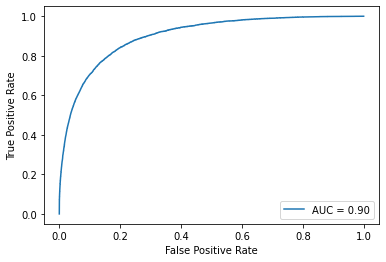

Test


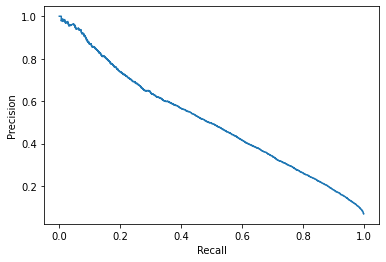

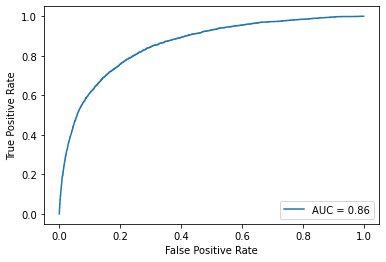

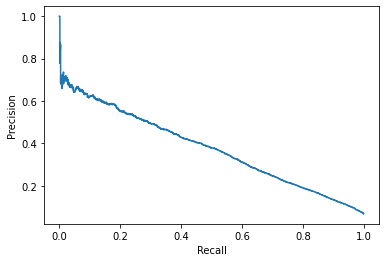

In [8]:
lgbm_model_3_train_test = fit_and_eval(LightGBMClassifier, X_train, X_test, y_train, y_test)

print("Train")
plot_roc(lgbm_model_3_train_test, X_train, y_train)
plot_pr(lgbm_model_3_train_test, X_train, y_train)

print("Test")
plot_roc(lgbm_model_3_train_test, X_test, y_test)
plot_pr(lgbm_model_3_train_test, X_test, y_test)

## Quick-and-Dirty Hyperparameter Search
Do k-fold cross validation over different hyperparameters & get the average AUC. Then pick the config with the highest and train 1 more final model using those hyperparams on the whole dataset

In [9]:
def kfold_fit_v2(df, n_splits, model_class, model_kwargs=None):
    if model_kwargs is None:
        model_kwargs = {}

    X, y = get_xy(df)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    aucs = []
    for irun, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = copy.deepcopy(X.iloc[train_index, :]), copy.deepcopy(X.iloc[test_index, :])
        y_train, y_test = copy.deepcopy(y.iloc[train_index]), copy.deepcopy(y.iloc[test_index])

        model = model_class(**model_kwargs)
        model.fit(X_train, y_train)
        iauc = eval_auc(model, X_test, y_test)
        aucs.append(iauc)

    print(f"AUCs: {aucs}")
    mean_auc = np.mean(aucs)

    return mean_auc


def quick_and_dirty_grid_search_xgboost(tree_model_class, df):
    res = []

    for nest in [10, 25, 50, 100]:
        for max_depth in [2, 3, 4, 5]:
            params = {'n_estimators': nest, 'max_depth': max_depth}

            mean_auc = kfold_fit_v2(df, 5, tree_model_class, params)

            print(f"params={params} - auc={mean_auc:.3f}")

            res.append((mean_auc, params))

    res.sort(key=lambda x: x[0], reverse=True)

    return res


def quick_and_dirty_grid_search_lightgbm(tree_model_class, df):
    res = []

    for nest in [50, 100, 200]:
        for btype in ['gbdt', 'dart', 'goss']:
            params = {'n_estimators': nest, 'boosting_type': btype}

            mean_auc = kfold_fit_v2(df, 5, tree_model_class, params)

            print(f"params={params} - auc={mean_auc:.3f}")

            res.append((mean_auc, params))

    res.sort(key=lambda x: x[0], reverse=True)

    return res

### LightGBM

In [10]:
df, _ = null_transform(raw_df)

res = quick_and_dirty_grid_search_lightgbm(LightGBMClassifier, df)

print("Top-5 params x AUCs:")
for ires in res[:5]:
    print(f"params={ires[1]} - auc={ires[0]}")

X, y = get_xy(df)

lgbm_tune = LightGBMClassifier(**res[0][1])
lgbm_tune.fit(X, y)
lgbm_tune.save("./data/models/lgbm_tune.pckl")

AUCs: [0.8627119908403673, 0.8616739095287321, 0.8662323295173391, 0.8722192999373329, 0.862474551253586]
params={'n_estimators': 50, 'boosting_type': 'gbdt'} - auc=0.865
AUCs: [0.8709956256827859, 0.8578584437281505, 0.8631284086622166, 0.867127599825227, 0.8621045261466801]
params={'n_estimators': 50, 'boosting_type': 'dart'} - auc=0.864
AUCs: [0.86694708864761, 0.8655719337127799, 0.8561798397380367, 0.8702884777696765, 0.8630197056029332]
params={'n_estimators': 50, 'boosting_type': 'goss'} - auc=0.864
AUCs: [0.8655562390488034, 0.8618031809207113, 0.8690341123437165, 0.8614876899553223, 0.8651534763733637]
params={'n_estimators': 100, 'boosting_type': 'gbdt'} - auc=0.865
AUCs: [0.8665232244966892, 0.8687907129835707, 0.8615465444265742, 0.8648306542092705, 0.8631119112381576]
params={'n_estimators': 100, 'boosting_type': 'dart'} - auc=0.865
AUCs: [0.8618657494687475, 0.8628702132862165, 0.864624480948014, 0.8575618464109418, 0.8674847262982034]
params={'n_estimators': 100, 'boosti

### XGBoost
Very slow

In [11]:
df, _ = null_transform(raw_df)

res = quick_and_dirty_grid_search_xgboost(XGBoostClassifier, df)

print("Top-5 params x AUCs:")
for ires in res[:5]:
    print(f"params={ires[1]} - auc={ires[0]}")

X, y = get_xy(df)

xgb_tune = XGBoostClassifier(**res[0][1])
xgb_tune.fit(X, y)
xgb_tune.save("./data/models/xgb_tune.pckl")

AUCs: [0.8459026186426075, 0.8425720659950409, 0.8458304943125308, 0.8401890790081413, 0.8475759075253462]
params={'n_estimators': 10, 'max_depth': 2} - auc=0.844
AUCs: [0.8522411795833477, 0.8515625029229035, 0.8513011541515918, 0.844799921966828, 0.8425823724311298]
params={'n_estimators': 10, 'max_depth': 3} - auc=0.848
AUCs: [0.8565486027450263, 0.8467381109647741, 0.8567251544295182, 0.8507594293423434, 0.8511967179746651]
params={'n_estimators': 10, 'max_depth': 4} - auc=0.852
AUCs: [0.857166195205909, 0.8501968689635082, 0.862373375366727, 0.8540208150814248, 0.8638826313391375]
params={'n_estimators': 10, 'max_depth': 5} - auc=0.858
AUCs: [0.8625134812038843, 0.860541689177663, 0.8567522611581423, 0.8676172490723539, 0.8498869098017593]
params={'n_estimators': 25, 'max_depth': 2} - auc=0.859
AUCs: [0.8612293700451835, 0.8649674349578811, 0.8680707500760511, 0.8572869576371627, 0.8628184227767783]
params={'n_estimators': 25, 'max_depth': 3} - auc=0.863
AUCs: [0.8672460951787775,

# Predict & Save

In [12]:
def generate_outputs(model, transform, input_csv, output_csv):
    model_with_transform = Ensemble()
    model_with_transform.add_model(model, weight=1.0, transform=transform)

    generate_test_output(input_csv, model_with_transform, output_csv)

In [13]:
generate_outputs(LightGBMClassifier("./data/models/lgbm_model_3.pckl"), 
                 null_transform, "./data/dataset/cs-test.csv", "./data/outputs/pred_out_lgbm_3.csv")

# Kaggle AUC=0.86784
generate_outputs(LightGBMClassifier("./data/models/lgbm_tune.pckl"), 
                 null_transform, "./data/dataset/cs-test.csv", "./data/outputs/pred_out_lgbm_tune.csv")

generate_outputs(XGBoostClassifier("./data/models/xg_cls_model_3.pckl"), 
                 null_transform, "./data/dataset/cs-test.csv", "./data/outputs/pred_out_xg_3.csv")

# Kaggle AUC=0.86651
generate_outputs(XGBoostClassifier("./data/models/xgb_tune.pckl"), 
                 null_transform, "./data/dataset/cs-test.csv", "./data/outputs/pred_out_xgb_tune.csv")

## Ensemble
Pick the best invididual model params one more grid search over the weight of each model (tuned trees & WoE binned logistic model)

In [17]:
woe_v2_transform = WoETransformV2()
woe_v2_transform.load("./data/models/woe_fit_v2.pckl")

X, y = get_xy(raw_df)
skf = StratifiedKFold(n_splits=5, shuffle=True)

aucs = defaultdict(list)
for irun, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = copy.deepcopy(X.iloc[train_index, :]), copy.deepcopy(X.iloc[test_index, :])
    y_train, y_test = copy.deepcopy(y.iloc[train_index]), copy.deepcopy(y.iloc[test_index])
    
    X_train_null, _ = null_transform(X_train)
    X_train_woe_v2, _ = woe_v2_transform(X_train)
    
    xgb_tune = XGBoostClassifier(**{'n_estimators': 100, 'max_depth': 3})
    lgbm_tune = LightGBMClassifier(**{'n_estimators': 200, 'boosting_type': 'dart'})
    sm_lg_v2 = StatsModelsLogisticRegression()

    xgb_tune.fit(X_train_null, y_train)
    lgbm_tune.fit(X_train_null, y_train)
    sm_lg_v2.fit(X_train_woe_v2, y_train)
    
    for iw1 in range(5 + 1):
        iw23_rem = 5 - iw1
    
        for iw2 in range(iw23_rem + 1):
            iw3 = 5 - iw2 - iw1

            w1 = 0.2 * iw1
            w2 = 0.2 * iw2
            w3 = 0.2 * iw3

            ens = Ensemble()
            ens.add_model(sm_lg_v2, weight=w1, transform=woe_v2_transform)
            ens.add_model(xgb_tune, weight=w2, transform=null_transform)
            ens.add_model(lgbm_tune, weight=w3, transform=null_transform)

            y_pred = ens.predict(X_test)
            iauc = roc_auc_score(y_test, y_pred)

            # print(f"w1={w1:.2f}, w2={w2:.2f}, w3={w3:.2f}, auc={iauc:.3f}")
    
            aucs[(iw1, iw2, iw3)].append(iauc)

final_aucs = [(tuple([0.2 * ik for ik in k]), np.mean(v)) for k, v in aucs.items()]
final_aucs.sort(key=lambda x: x[1], reverse=True)
for ifinal_auc in final_aucs[:5]:
    print(f"weights={ifinal_auc[0]}, auc={ifinal_auc[1]}")

weights=(0.0, 0.4, 0.6000000000000001), auc=0.8663531161512432
weights=(0.0, 0.6000000000000001, 0.4), auc=0.8662428746351722
weights=(0.0, 0.2, 0.8), auc=0.8661450963592319
weights=(0.0, 0.8, 0.2), auc=0.8657904502091046
weights=(0.0, 0.0, 1.0), auc=0.8655954105493462


Turns out the best model has 0 weight for logistic so we will drop that model from the final ensemble which uses 40% weighted score from XGBoost and 60% from LightGBM. The final kaggle private score for this model is 0.86810, which is ~50th in the Private Scores (100th=0.86723, 1st=0.86955)

In [18]:
xgb_tune = XGBoostClassifier("./data/models/xgb_tune.pckl")
lgbm_tune = LightGBMClassifier("./data/models/lgbm_tune.pckl")

final_ens = Ensemble()
final_ens.add_model(xgb_tune, weight=0.4, transform=null_transform)
final_ens.add_model(lgbm_tune, weight=0.6, transform=null_transform)

In [19]:
# Kaggle AUC=0.86825
generate_test_output("./data/dataset/cs-test.csv", final_ens, "./data/outputs/final_ens.csv")

,id,Probability
0,1,0.077253
1,2,0.059796
2,3,0.016305
3,4,0.081317
4,5,0.129112
...,...,...
101498,101499,0.032261
101499,101500,0.351189
101500,101501,0.006172
101501,101502,0.077522
